In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle
import warnings
from itertools import product
warnings.filterwarnings("ignore", message="y_pred contains classes not")

from IPython.display import display
import torch
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes('deep')
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
plt.style.use('seaborn-v0_8-muted')
from sklearn.metrics import mean_absolute_error, mean_squared_error, balanced_accuracy_score

from braindecode.datasets.tuh import TUHAbnormal
from braindecode.preprocessing import create_fixed_length_windows

from decode_tueg import (
    DataScaler, TargetScaler, trial_age_mae, Augmenter, ChannelsSymmetryFB,
    get_datasets, test_name, create_windows, create_final_scores,
    plot_age_gap_hist, accuracy_perumtations, 
    age_gap_diff_permutations,
    plot_learning_curves, save_fig, read_result,
    load_exp, predict_ds, plot_heatmaps, plot_age_gap_hist_and_permutation_test,
    plot_age_gap_hist_with_thresh_and_permutation_test, deconfound,
    fit_deconfound_model, 
)

Wed May 10 08:15:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:B2:00.0 Off |                  N/A |
| 27%   24C    P8    22W / 250W |   2079MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# TODO: 
# mail denis
# mail joschka
# improve handling of cv / final eval in this notebook
# rename eval back to valid? makes things easier
# always compute mean over folds and afterwards over seeds?

In [4]:
#work_dir = '/home/jovyan/workspace-tueg/'
work_dir = '/home/jovyan/'
#work_dir = '/home/lukas/Code/brain_age/'

In [5]:
base_dir = os.path.join(work_dir, 'experiments')
# exp = '2022-10-07T14:07:06.646966'  # deep all ages, lr=0.005
# exp = '2022-10-06T09:37:01.278443'  # deep all ages, lr=0.01
# exp = '2022-10-05T14:36:25.074269'  # shallow all ages
# exp = '2022-09-28T10:25:47.571160'  # shallow ages >= 18
# exp = '2022-09-28T22:24:18.385389'  # TCN all ages, still with 'valid_rest'
# exp = '2022-10-06T20:10:52.312837'  # TCN all ages, 5 seeds
# exp = '2022-09-29T15:49:14.606557'  # TCN ages >= 18
# exp = '2022-10-08T08:04:26.625918'  # TCN matched patho and non-patho dist in all ages
# exp = '2022-10-09T09:55:45.307781'  # TCN uniformly matched patho and non-patho age dist in >=18 and <=86
# exp = '2022-10-09T12:02:46.142332'  # TCN all ages, sign augmentation isntead of dropout
# exp = '2022-10-12T08:10:43.911642'  # TCN all ages age_clf

#exp = '2022-10-12T11:25:00.490417'  # TCN exluding recs with age divergence, cv
#exp = '2022-10-17T16:24:10.124445'  # TCN exluding recs with age divergence, final eval

#exp = '2023-02-07T06:28:03.373666' # TCN exluding recs with age divergence, subject-wise cv
#exp = '2023-02-09T09:34:21.685021' # TCN exluding recs with age divergence, subject-wise fe 


#exp = '2023-02-10T23:14:51.938016'  # mixed patho and non-patho data
#exp = '2023-02-11T09:11:11.990975'  # subset non-patho, match patho and non-patho dists
#exp = '2023-02-11T09:11:23.883557'  # subset non-patho, uniform patho and non-patho dists

exp = '2023-02-15T18:59:11.767923'  # cv, l1loss
#exp = '2023-02-15T18:43:26.819382'  # fe, l1loss
#exp = '2023-05-04T08:38:44.048946'  # cv, l2loss
#exp = '2023-05-08T09:22:38.974401'  # fe, l2loss  # currently re-running with longitudinals
#exp = '2023-05-09T09:15:59.256046'  # fe, l2loss  # longitudinal crashed

#exp = '2023-02-22T12:51:02.928667'


exp_dir = os.path.join(base_dir, exp)

In [6]:
configs = read_result(exp_dir, 'config')

In [7]:
assert len(configs) == 5

In [8]:
configs.iloc[0]

augment                                                                dropout
batch_size                                                                 128
data_path                    /home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...
date                                                2023-02-15T18:59:11.767923
debug                                                                        1
fast_mode                                                                    1
final_eval                                                                   0
intuitive_training_scores                                                    1
loss                                                                       mae
max_age                                                                     -1
min_age                                                                     -1
model_name                                                                 tcn
n_epochs                                            

In [9]:
assert configs['final_eval'].nunique() == 1

In [10]:
configs[['model_name', 'target_name', 'valid_set_i', 'seed', 'final_eval']]

,model_name,target_name,valid_set_i,seed,final_eval
0,tcn,age,0,20230214,0
1,tcn,age,1,20230214,0
2,tcn,age,2,20230214,0
3,tcn,age,3,20230214,0
4,tcn,age,4,20230214,0


In [11]:
scores = read_result(exp_dir, 'score')

In [12]:
def average_scores(scores):
    scores_ = {}
    for score in scores.index.unique():
        for subset in scores.columns:
            if subset not in scores_:
                scores_[subset] = {}
            scores_[subset].update({score: scores.loc[score, subset].mean()})
    return pd.DataFrame(scores_).drop(['seed', 'valid_set_i'], axis=1)

In [13]:
average_scores(scores)

,train,valid,valid_not_normal
mae,2.457476,6.512740,10.983237
mape,0.060588,0.157811,0.215597
mdae,1.552273,5.271109,8.459125
mdape,0.037949,0.124280,0.169852
r2,0.946925,0.714132,0.269829


In [14]:
histories = read_result(exp_dir, 'history')

In [15]:
loss = configs['loss'].unique()
assert len(loss) == 1
loss = loss[0]
if loss == 'mae':
    loss_label = 'L1 Loss' 
elif loss == 'mse':
    loss_label = 'L2 Loss'
else:
    raise NotImplementedError

In [16]:
fe = (configs['final_eval'] == '1').all()

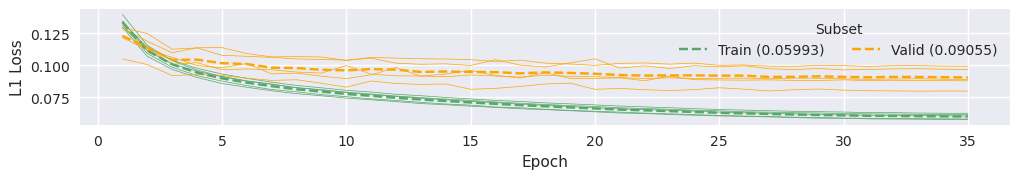

In [17]:
if fe:
    histories['eval_run_i'] = (histories['epoch'] == 1).cumsum() - 1
    ax = plot_learning_curves([g2 for n2, g2 in histories.groupby('eval_run_i')], loss_label, 'Eval')
    ax.get_figure().savefig(os.path.join(work_dir, 'final_eval_curves.png'), dpi=300, bbox_inches='tight')
else:
    for n1, g1 in histories.groupby('seed'):
        ax = plot_learning_curves([g2 for n2, g2 in g1.groupby('valid_set_i')], loss_label)
        # ax.set_title(f'Deep4, lr=0.005')
        # ax.set_title(f'Seed: {n1}')
        ax.get_figure().savefig(os.path.join(work_dir, f'cv_curves_{n1}.png'), dpi=300, bbox_inches='tight')

In [78]:
# for cv, 5 seeds of 5 runs with different data splits -> grouper = subset, seed
# for cv, 5 runs with same seed but different data splits -> grouper = 
# for fe, 5 runs with different seed but same data splits -> grouper = subset, index
preds = read_result(exp_dir, 'preds')
preds.shape

(2475, 20)

In [79]:
def prepare_preds(g1, sex, min_age, max_age):
    g1 = g1[g1.gender==sex] if sex is not None else g1
    max_age = g1.age.max() if max_age is None else max_age
    min_age = g1.age.min() if min_age is None else min_age
    g1 = g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)].copy()
    # if fe, average over different seeds; if cv, basically don't average
    grouper = ['subset', 'index'] if fe else ['subset', 'subject', 'session', 'segment', 'seed']
    # after averaging, seed variable does not make sense anymore, so drop it
    g1 = g1.reset_index().groupby(grouper, as_index=False).mean(numeric_only=True)#.drop(['seed'], axis=1)
    g1 = g1.groupby(['subset', 'pathological', 'subject'], as_index=False).mean(numeric_only=True)
    return g1

In [88]:
def add_deconfounded_predictions(g1):
    coefs = fit_deconfound_model(
        g1[g1.pathological == False].y_true, 
        g1[g1.pathological == False].y_pred, 
    )
    g1['y_pred_confounded'] = g1.y_pred
    for kind, coef in coefs.items():
        g1[f'y_pred_deconfounded_{kind}'] = g1.y_pred - [coefs_to_func(coef, y) for y in g1.y_true]
    return g1, coefs

In [89]:
preds = prepare_preds(preds, sex=None, min_age=None, max_age=None)
preds.shape

(1986, 21)

In [90]:
preds, coeffs = add_deconfounded_predictions(preds)
preds.shape

(1986, 21)

In [ ]:
coeffs

{'linear': (-0.3633842036226892, 15.389209182923198),
 'quadratic': (-0.004439919249547616,
  0.058409175365495655,
  6.5604274180671736)}

In [99]:
# from list of coeffs generate a string representing the function formula
def coefs_to_func_str(coefs):
    s = ''.join([f' + {coef:.2E}'+'x'*i if coef >= 0 else f'{coef:.2E}'+'x'*i for i, coef in enumerate(coefs[::-1])][::-1])
    if s.startswith('+'):
        s = s[2:]
    return 'f(x) = ' + s


# from list of coeffs compute the result of the represented function
def coefs_to_func(coefs, x):
    return sum([coef*x**i for i, coef in enumerate(coefs[::-1])][::-1])


# plot bias of model that is being fit: ytrue to ypred-ytrue
def plot_true_age_vs_gap(y_true, y_pred, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.scatter(y_true, y_pred-y_true, facecolor='b', edgecolor='k', alpha=.5)
    ax.plot([0,100],[0,0], c='k')
    ax.set_xlabel('Chronological Age [years]')
    ax.set_ylabel('Brain Age Gap\n[years]')
    ax.legend();
    return ax


def plot_model_bias(y_true, y_pred, coeffs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax = plot_true_age_vs_gap(preds.y_true, preds.y_pred, ax=ax)
    """
    for coefs, line_params in [
        (quadratic_model_params, {'linestyle': '-'}),
       # ([-4.43177352e-03, 5.75292131e-02, 6.58223507e+00], {'linestyle': '-'}),
        (linear_model_params, {'linestyle': '--'}),
       # ([-0.36310181197536046, 15.374280445171014], {'linestyle': '--'}),
    ]:
    """
    for kind, coefs in coeffs.items():
        ax.plot(
            [coefs_to_func(coefs, p) for p in np.arange(100)], 
            label=coefs_to_func_str(coefs), linewidth=1,
        )
    ax.legend()
    return ax

In [100]:
# TODO: save models to disk in cv, read in fe

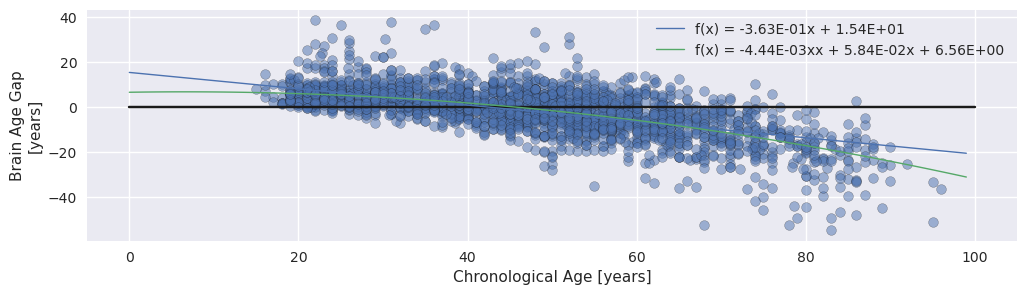

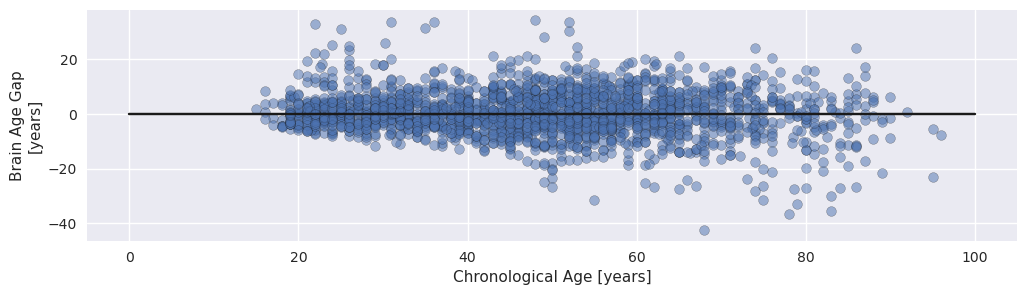

In [110]:
ax = plot_model_bias(
    preds.y_true, preds.y_pred,
    coeffs,
    #[-4.43177352e-03, 5.75292131e-02, 6.58223507e+00],
    #[-0.36310181197536046, 15.374280445171014],
)
ax = plot_true_age_vs_gap(preds.y_true, preds.y_pred_deconfounded_quadratic)

In [102]:
bin_width = 2
n_repetitions = 100

1.00E-02
found thresholds -8.247981190681458 10.821904003620148
1.00E-02


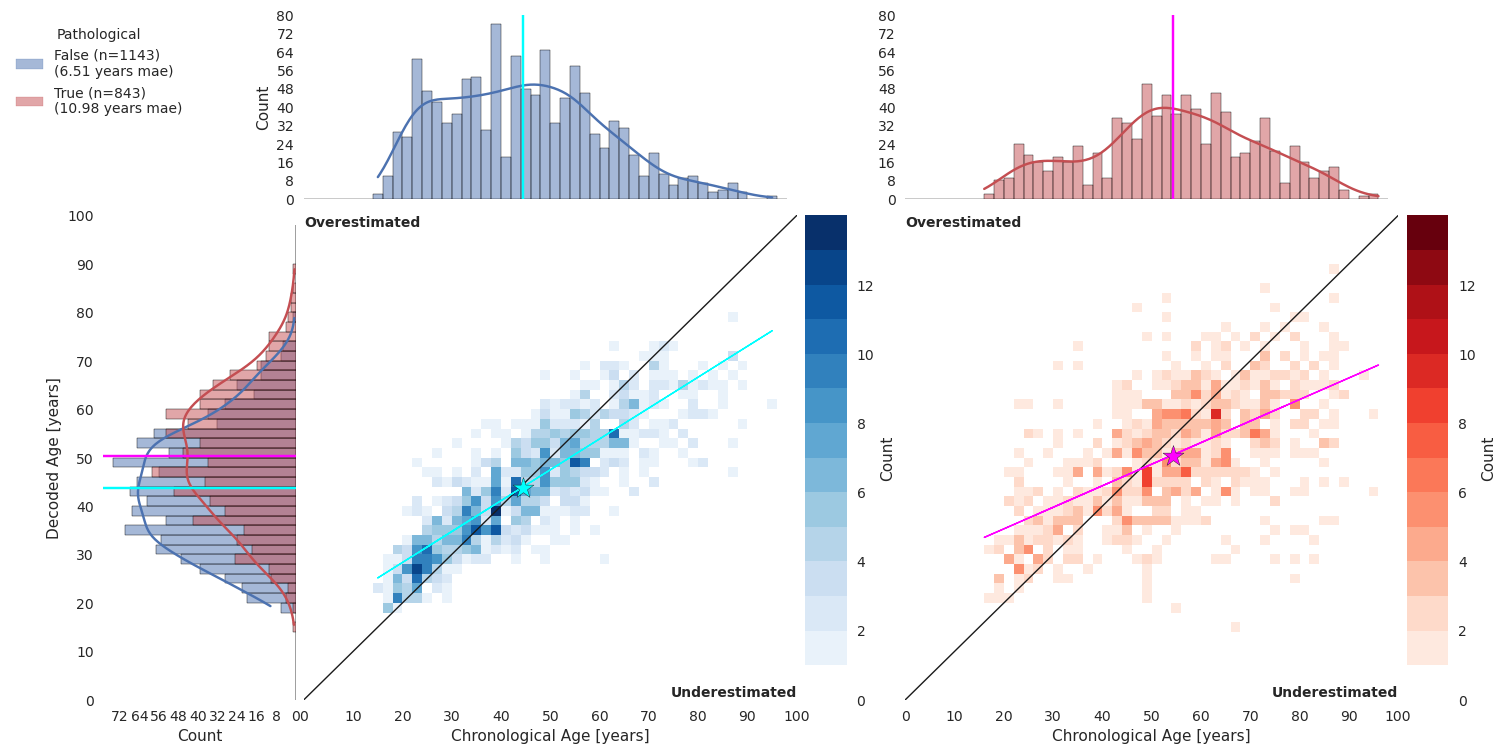

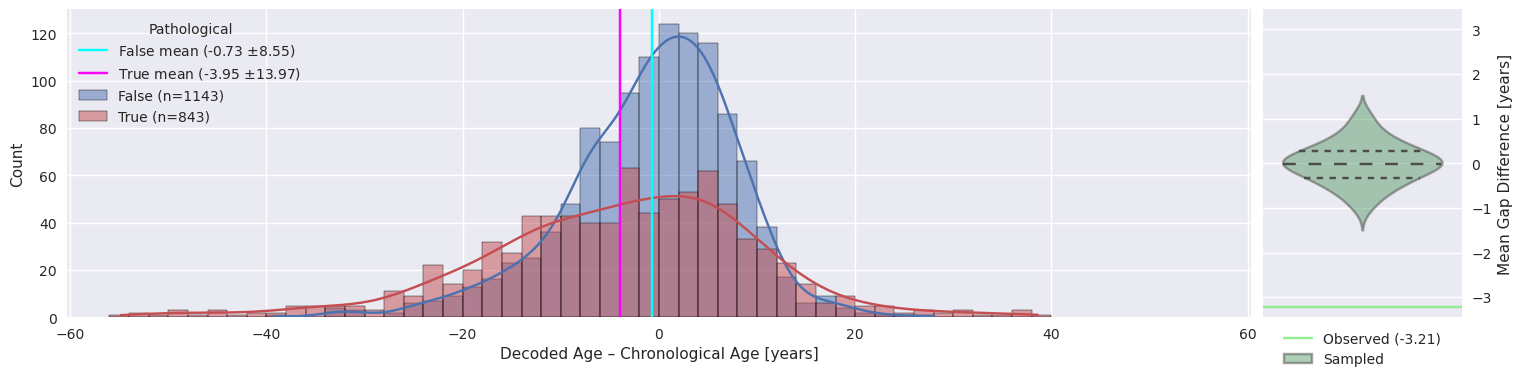

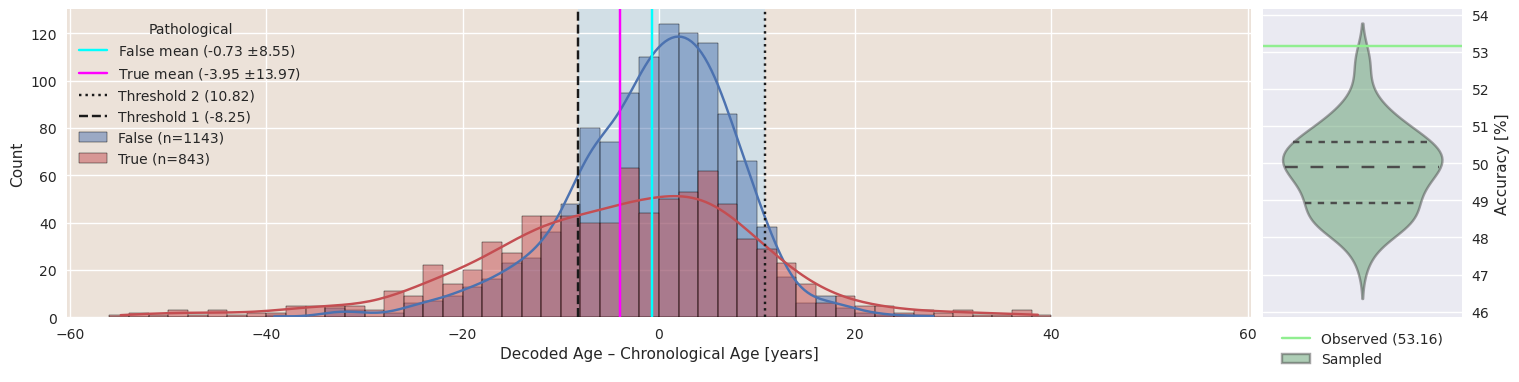

In [108]:
ax = plot_heatmaps(preds, bin_width)
ax = plot_age_gap_hist_and_permutation_test(preds, bin_width, n_repetitions)
ax = plot_age_gap_hist_with_thresh_and_permutation_test(
    preds, bin_width, n_repetitions, 
    t_low=None if not fe else thresh1, 
    t_high=None if not fe else thresh2,
)

In [21]:
bin_width = 2
n_repetitions = 100  # ! actually 100000 !
cols = ['y_pred', 'y_true', 'pathological', 'subject', 'index', 'subset']

In [22]:
if n_repetitions != 100000:
    print("WARNING! Wrong number of reps!")

WARNING! Wrong number of reps!


In [23]:
save = False
age_limits = [(None, None)]# [(None, 30), (30, 60), (60, None)]  #[(None, 30), (30, 60), (60, None)]#
sexes = [None]#['F', 'M'] #[None]#
detrend = True  # None, linear, quadratic
# extracted from cv
thresh1 = -7.186685473771377 if fe and None not in detrends else None 
thresh2 = 5.955300372252786 if fe and None not in detrends else None
#thresh1 = None
#thresh2 = None

In [24]:
thresh1, thresh2

(None, None)

In [25]:
# TODO: fine to apply deconfound model from CV in FE?
# TODO: fit model in cv and save to disk, load again in FE to apply

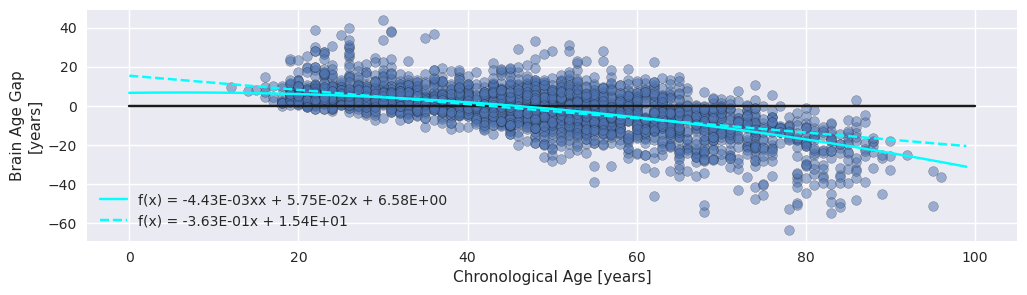

In [239]:
ax = plot_model_bias(
    preds.y_true, preds.y_pred,
    [-4.43177352e-03, 5.75292131e-02, 6.58223507e+00],
    [-0.36310181197536046, 15.374280445171014],
)

12 96 None True None None
1.00E-02
           2
-0.004432 x + 0.05753 x + 6.582
4.00E-02
           2
-0.004432 x + 0.05753 x + 6.582
found thresholds -7.186685473771377 5.955300372252786
1.00E-02


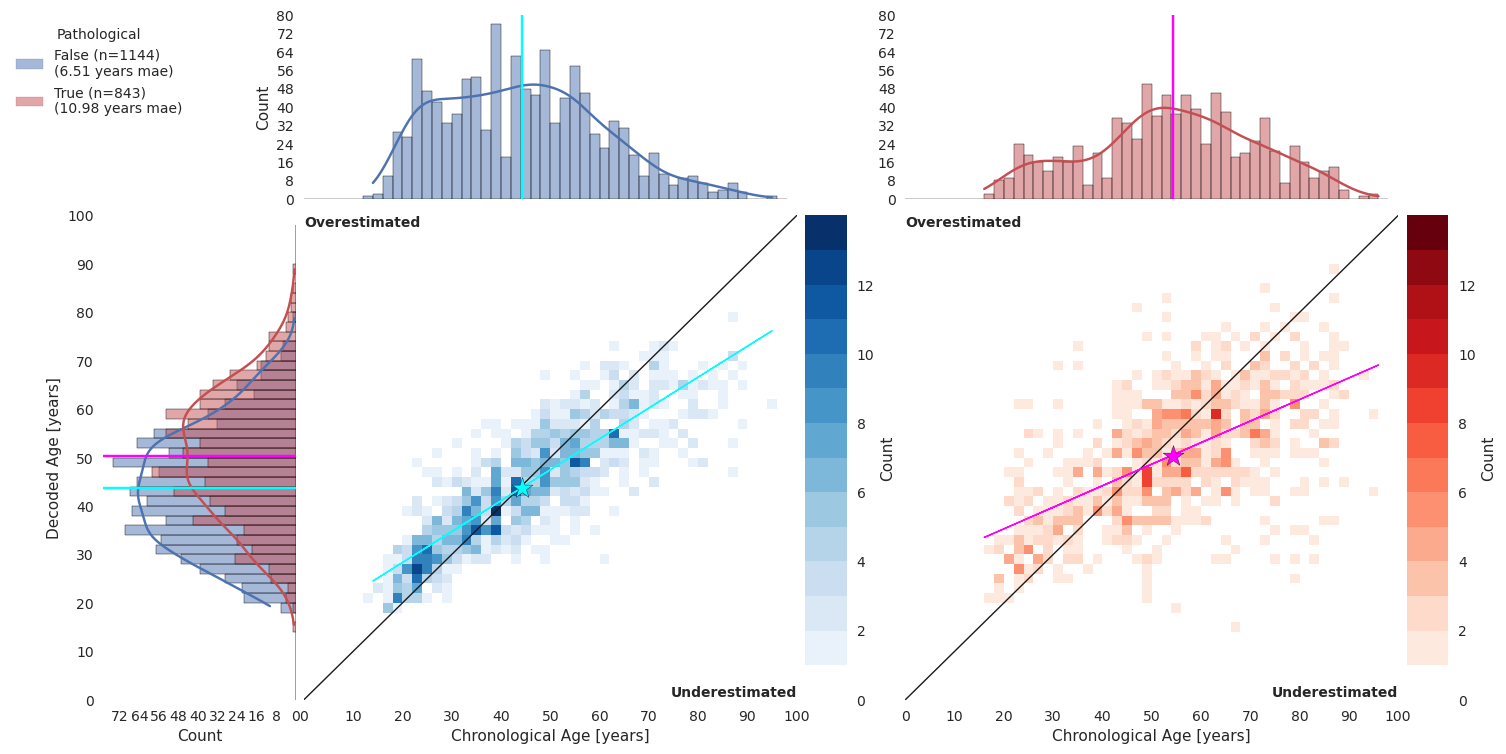

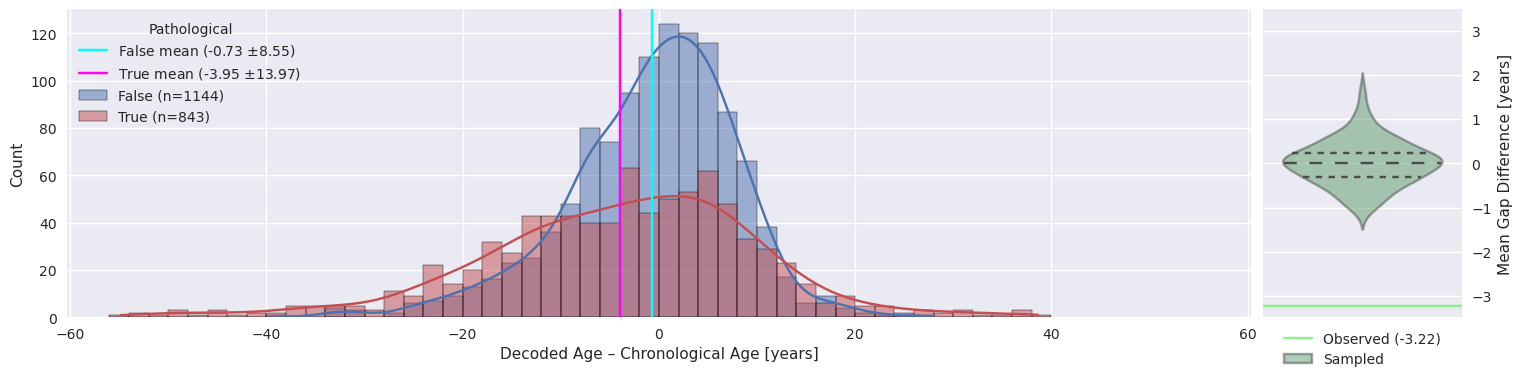

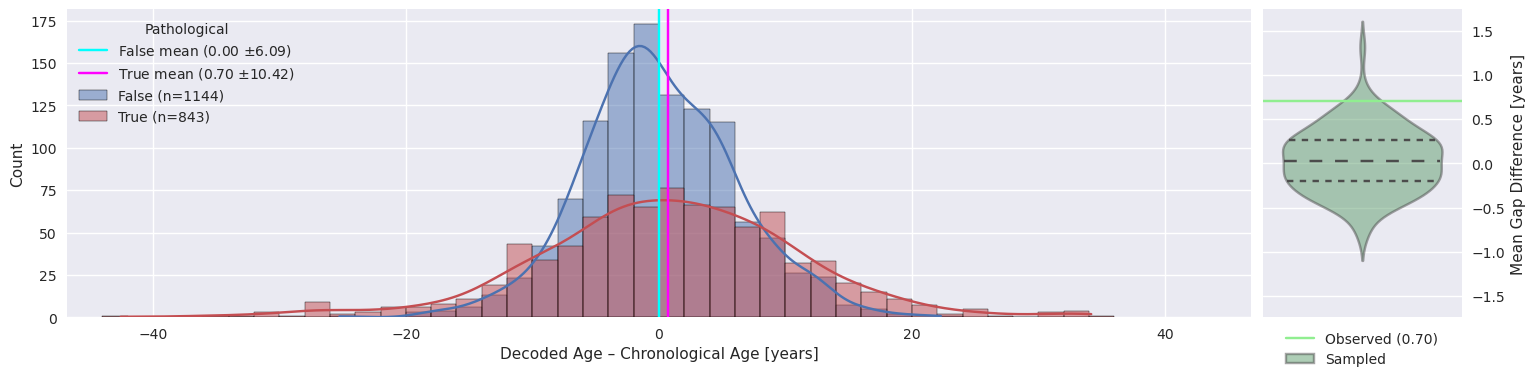

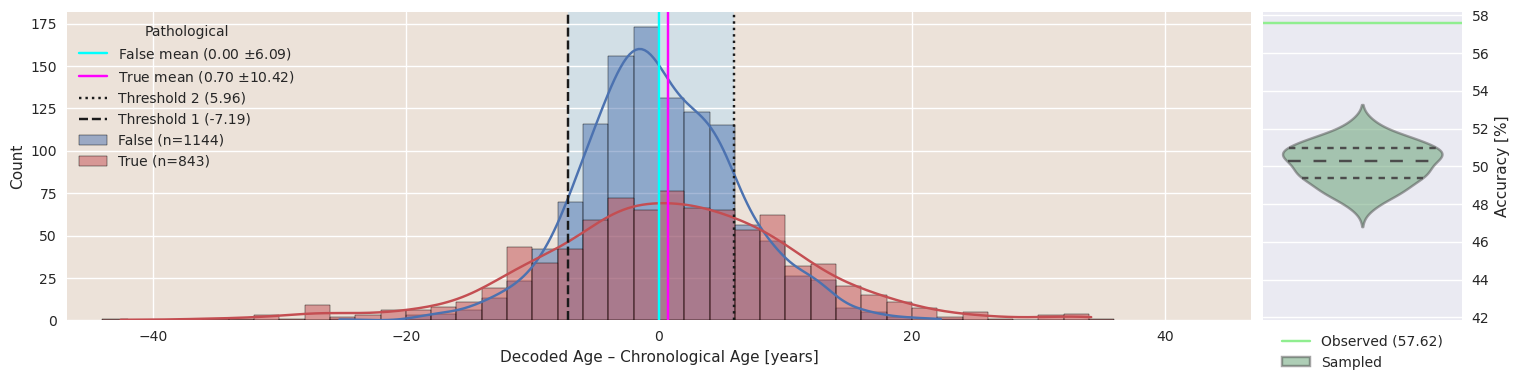

In [201]:
for (min_age, max_age), sex in product(age_limits, sexes):
    max_age = preds.age.max() if max_age is None else max_age
    min_age = preds.age.min() if min_age is None else min_age
    print(min_age, max_age, sex, detrend, thresh1, thresh2)
    # actual predictions can never be detrended for heatmaps as this would be cheating
    ax, _ = plot_things('heatmap', preds, configs, sex, min_age, max_age, cols, model if fe else False, bin_width)
    if save:
        ax.get_figure().savefig('/home/jovyan/eval_heatmaps.jpg', bbox_inches='tight', dpi=300)
    ax, _ = plot_things('gap', preds, configs, sex, min_age, max_age, cols, model if fe else False, bin_width)
    if save:
        ax.get_figure().savefig('/home/jovyan/eval_gaps.jpg', bbox_inches='tight', dpi=300)
    #ax, _ = plot_things('proxy', preds, configs, sex, min_age, max_age, cols, None, bin_width, thresh1, thresh2)
    #if save:
    #    ax.get_figure().savefig('/home/jovyan/eval_proxy.jpg', bbox_inches='tight', dpi=300)
    ax, _ = plot_things('gap', preds, configs, sex, min_age, max_age, cols, model if fe else detrend, bin_width)
    if save:
        ax.get_figure().savefig('/home/jovyan/eval_gaps_detrended.jpg', bbox_inches='tight', dpi=300)
    ax, models = plot_things('proxy', preds, configs, sex, min_age, max_age, cols, model if fe else detrend,
                            bin_width, thresh1, thresh2)
    if save:
        ax.get_figure().savefig('/home/jovyan/eval_proxy_detrended.jpg', bbox_inches='tight', dpi=300)

In [33]:
model

poly1d([-4.43177352e-03,  5.75292131e-02,  6.58223507e+00])

# FE analysis

In [112]:
import re

import mne

from decode_tueg import (
    deconfound, plot_age_gap_hist_and_permutation_test, 
    plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test,
    mean_abs_running_diff_of_mean_corrected_gaps, _reject_derivating_ages,
    plot_mean_abs_running_diff_of_mean_corrected_gaps,
)

In [113]:
def get_longitudinal_preds(ds_name, min_mins=None, clean_age=False):
    preds = read_result(exp_dir, f'longitudinal_{ds_name}')
    preds['path'] = [p.replace('/data/datasets/TUH/EEG/', '/home/jovyan/mne_data/TUH/') for p in preds.path]
    #preds.shape, preds.subject.nunique()

    if clean_age:
        #assert min_mins is not None
        gs = []
        for p, g in preds.groupby('path'):
            raw = mne.io.read_raw_edf(p, verbose='error')
            rec_year = raw.info['meas_date'].year
            # seems like one (?) header broke in preprocessing. read header of original unpreprocessed reocrding
            header = TUHAbnormal._read_edf_header(p)
            pattern = r'\d\d-\w\w\w-(\d\d\d\d)'
            matches = re.findall(pattern, str(header))
            if len(matches) != 1:
                birthyear = np.nan
            else:
                birthyear = int(matches[0])
            g['date_age'] = int(rec_year) - birthyear

            pattern = r'(\d+)[ -]+?[years]{3,5}[ -]+?[old]{3}'
            # is this also fine? also finds 33 y.o. often used in old reports
            #pattern = r'(\d+)[ -]+?[years]{1,5}[ -.]+?[old]{1,3}[ .]+?'  
            matches = re.findall(pattern, g.iloc[0].report)
            if len(matches) >= 1:
                # assume report always starts with 'XX year old ...'
                match = int(matches[0])
            elif len(matches) == 0:
                match = np.nan
            g['report_age'] = match
            gs.append(g)
        gs = pd.concat(gs).reset_index()
        gs.shape, gs.subject.nunique()

        preds = gs

        ids = _reject_derivating_ages(preds)
        preds = preds.iloc[ids]
        preds = preds.set_index('index')
        preds.shape, preds.subject.nunique()

    gs = []
    for seed, group in preds.groupby('seed'):
        group['duration'] = group.n_samples / group.sfreq
        if min_mins is not None:
            group = group[group.duration >= min_mins*60]
        # for eacht subject, there have to be at least two recs still after min duration selection
        for subject, g in group.groupby('subject'):
            if len(g) >= 2:
                # if this is transition, we require both pathologies
                if 'transition' in ds_name and g.pathological.nunique() != 2:
                    continue
                gs.append(g)
    gs = pd.concat(gs)
    return gs

In [155]:
def get_01_10_transitions(preds):
    gs_01, gs_10 = [], []
    for n, g in preds.groupby('subject'):
        #if len(g) == 2:
        if g.pathological.diff().sum() > 0:
            gs_10.append(g)
        elif g.pathological.diff().sum() < 0:
                gs_01.append(g)
        else:
            assert g.pathological.diff().sum() == 0
            #print(n)
    if gs_01:
        gs_01 = pd.concat(gs_01)
    if gs_10:
        gs_10 = pd.concat(gs_10)
    return gs_01, gs_10

In [156]:
def counts(preds):
    rec_preds = preds.copy()
    print(f'{len(rec_preds)} recs of {rec_preds.subject.nunique()} subjects')
    # TODO: don't use seed here
    for seed, group in rec_preds.groupby('seed'):
        break
    print(f'per seed {len(group)} recs of {group.subject.nunique()} subjects')
    print(f"thereof female {group.groupby('subject').head(1).gender.value_counts()}")

In [159]:
ds_name = 'pathological'  # non_pathological, pathological, transition
min_mins = 15
clean_age = True

In [160]:
# these are predictions of five repetitions of fe
rec_preds = get_longitudinal_preds(ds_name, min_mins, clean_age)

In [161]:
# map gender from M, F to 0, 1
assert sorted(rec_preds.gender.unique()) == ['F', 'M']
rec_preds['gender'] = rec_preds.gender == 'F'
counts(rec_preds)

13395 recs of 1046 subjects
per seed 2679 recs of 1046 subjects
thereof female True     530
False    516
Name: gender, dtype: int64


In [163]:
# average predictions over five runs of fe

In [164]:
grouper = ['subset', 'index']
rec_preds = rec_preds.reset_index().groupby(grouper, as_index=False).mean(numeric_only=True)#.drop(['seed'], axis=1)

# deconfound predictions

In [165]:
rec_preds['y_pred_confounded'] = rec_preds['y_pred']
rec_preds['y_pred_deconfounded'] = rec_preds.y_pred - model(rec_preds.y_true)

In [166]:
# average over seeds / runs, subject, subset, and pathology status
subj_preds = rec_preds.groupby(['subset', 'subject', 'pathological'], as_index=False).mean(numeric_only=True)

In [167]:
counts(subj_preds)

1046 recs of 1046 subjects
per seed 1046 recs of 1046 subjects
thereof female 1.0    529
0.0    515
0.5      2
Name: gender, dtype: int64


In [168]:
bin_size = 2
n_repetitions = 100
#detrend = True
#thresh1 = -8.786315726356626 
#thresh2 = 4.877341101987973 
#thresh1 = -7.186685473771377
#thresh2 = 5.955300372252786

<AxesSubplot: xlabel=' '>

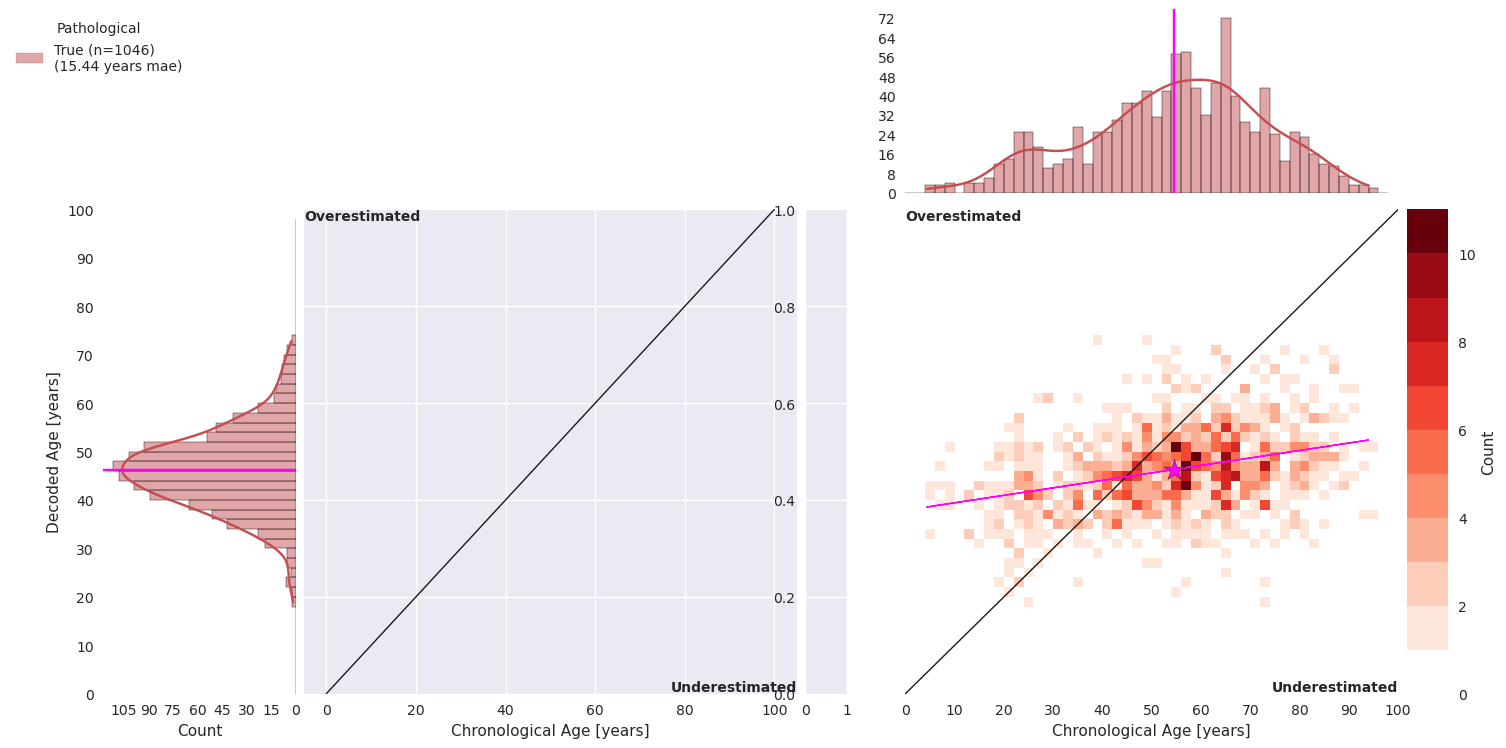

In [169]:
# TODO: when only one pathology status, plot into left square, drop second
#plot_heatmaps(rec_preds, bin_size)
plot_heatmaps(subj_preds, bin_size)

In [170]:
if ds_name.startswith('transition'):
    gs_01, gs_10 = get_01_10_transitions(rec_preds)
    counts(gs_01)
    print()
    counts(gs_10)

    # average over runs / seeds
    gs_01_subj = gs_01.groupby(['subject', 'pathological'], as_index=False).mean(numeric_only=True)
    gs_10_subj = gs_10.groupby(['subject', 'pathological'], as_index=False).mean(numeric_only=True)

    #plot_heatmaps(gs_01, bin_size)
    plot_heatmaps(gs_01_subj, bin_size)
    #plot_heatmaps(gs_10, bin_size)
    plot_heatmaps(gs_10_subj, bin_size)

In [171]:
# for following analyses, only use deconfounded predictions
rec_preds['y_pred'] = rec_preds['y_pred_deconfounded']
subj_preds['y_pred'] = subj_preds['y_pred_deconfounded']

# all transitions

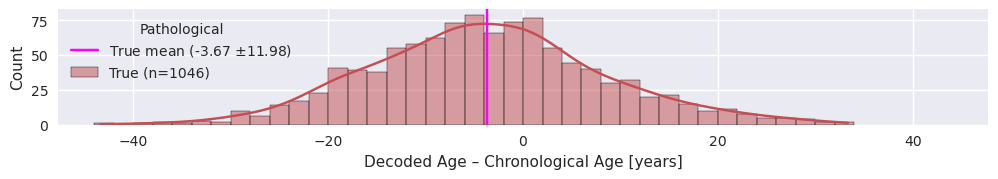

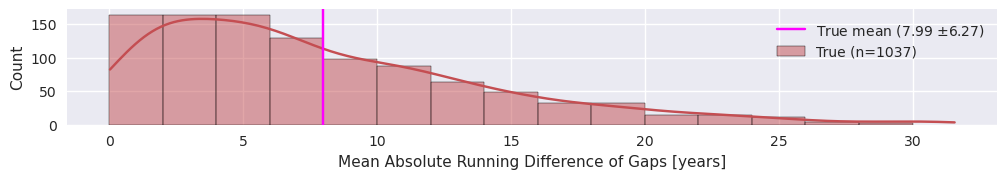

In [172]:
if ds_name.startswith('transition'):
    plot_age_gap_hist_and_permutation_test(subj_preds, bin_size, n_repetitions)
    plot_age_gap_hist_with_thresh_and_permutation_test(
        subj_preds,
        bin_size,
        n_repetitions,
        thresh1,
        thresh2,
    )
    plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test(
        mean_abs_running_diff_of_mean_corrected_gaps(rec_preds), 
        n_repetitions,
    )
else:
    plot_age_gap_hist(subj_preds, bin_size)
    plot_mean_abs_running_diff_of_mean_corrected_gaps(
        mean_abs_running_diff_of_mean_corrected_gaps(rec_preds),
    )

# 01 transitions

In [173]:
if ds_name.startswith('transition'):
    plot_age_gap_hist_and_permutation_test(gs_01_subj, bin_size, n_repetitions)
    plot_age_gap_hist_with_thresh_and_permutation_test(
        gs_01_subj,
        bin_size,
        n_repetitions,
        thresh1,
        thresh2,
    )
    plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test(
        mean_abs_running_diff_of_mean_corrected_gaps(gs_01), 
        n_repetitions,
    )

# 10 transitions

In [174]:
if ds_name.startswith('transition'):
    plot_age_gap_hist_and_permutation_test(gs_10_subj, bin_size, n_repetitions)
    plot_age_gap_hist_with_thresh_and_permutation_test(
        gs_10_subj,
        bin_size,
        n_repetitions,
        thresh1,
        thresh2,
    )
    plot_mean_abs_running_diff_of_mean_corrected_gaps_and_permutation_test(
        mean_abs_running_diff_of_mean_corrected_gaps(gs_10), 
        n_repetitions,
    )

In [175]:
# TODO: understand what is n_subjects and why there is so many less data points in running diff plot. is it due to diff?

# plot recording durations and intervals

In [27]:
all_rec_preds = []
for ds_name in ['non_pathological', 'pathological', 'transition']:
    all_rec_preds.append(get_longitudinal_preds(ds_name, min_mins, clean_age))
    if ds_name == 'non_pathological':
        name = 'Non-pathological' 
    elif ds_name == 'pathological':
        name = 'Pathological'
    else:
        name = 'Transition'
    all_rec_predſ[-1]['Longitudinal'] = name
all_rec_preds = pd.concat(all_rec_preds)

In [28]:
all_rec_preds.shape

Fri Mar 31 08:14:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:1B:00.0 Off |                  N/A |
| 27%   27C    P8     1W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

(17970, 27)

In [29]:
(all_rec_preds.n_samples / all_rec_preds.sfreq).max()

76738.0

In [30]:
all_rec_preds.subset.unique()

array(['longitudinal_non_pathological', 'longitudinal_pathological',
       'longitudinal_transition'], dtype=object)

In [31]:
def plot_recording_durations(all_rec_preds, tmax=25, stepsize=1, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12,3))
    all_rec_preds.duration.clip(upper=tmax*60, inplace=True)
    bins = [t*60 for t in range(2, tmax+1, stepsize)]
    ax = sns.histplot(
        data=all_rec_preds,
        x='duration',
        hue='Longitudinal',
        palette=['b', 'r', 'g'],
        bins=bins,
        multiple='stack',
        alpha=.5,
    )
    tick_bins = [t for t in [2, 5, 10, 15, 20, 25]]
    ax.set_xticks([t*60 for t in tick_bins]);
    ax.set_xticklabels([f'{t}*60' for t in tick_bins]);
    return ax

(840.0, 1569.0)

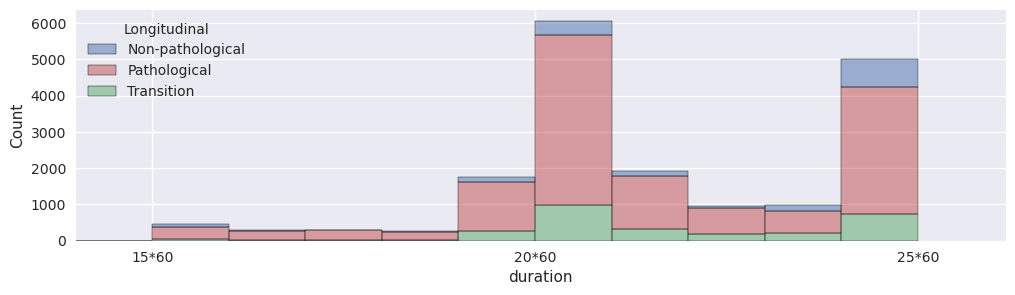

In [37]:
ax = plot_recording_durations(all_rec_preds)
ax.set_xlim((min_mins-1)*60)

In [38]:
from datetime import datetime

In [39]:
from decode_tueg import plot_n_recs_per_subject_and_rec_intervals

In [46]:
# information is there from 5 repetitions of fe. only choose one
all_rec_preds = all_rec_preds[all_rec_preds.seed==20230214]

In [47]:
n_recs_per_subject = all_rec_preds.groupby(['Longitudinal', 'subject'], as_index=False).size()

In [48]:
(n_recs_per_subject.size > 2).all()

True

In [49]:
# sort the dataframe for correct computation of day diffs
all_rec_preds = all_rec_preds.sort_values(['Longitudinal', 'year', 'month', 'day'])

In [50]:
day_diffs = []
for (dataset, subj), group in all_rec_preds.groupby(['Longitudinal','subject']):
    dates = [datetime(y, m, d) for i, (y, m, d) in group[['year', 'month', 'day']].iterrows()]
    for i in range(1, len(dates)):
        day_diffs.append((dataset, (dates[i] - dates[i-1]).days, subj))
day_diffs = pd.DataFrame(day_diffs, columns=['Dataset', 'Interval [days]', 'Subject'])

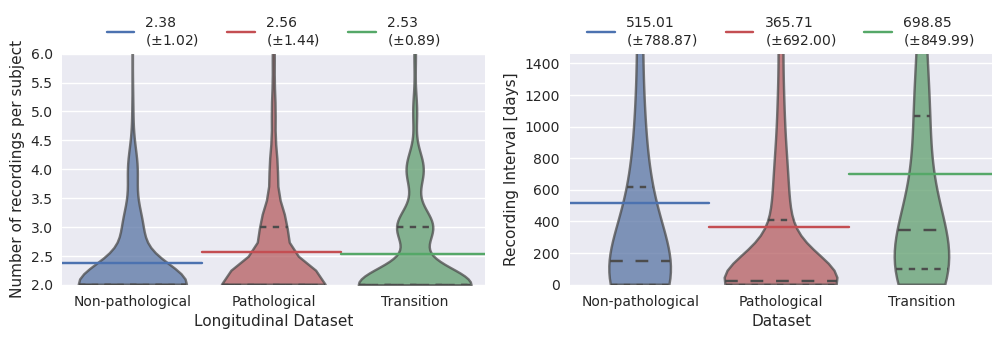

In [51]:
ax_arr = plot_n_recs_per_subject_and_rec_intervals(n_recs_per_subject, day_diffs)

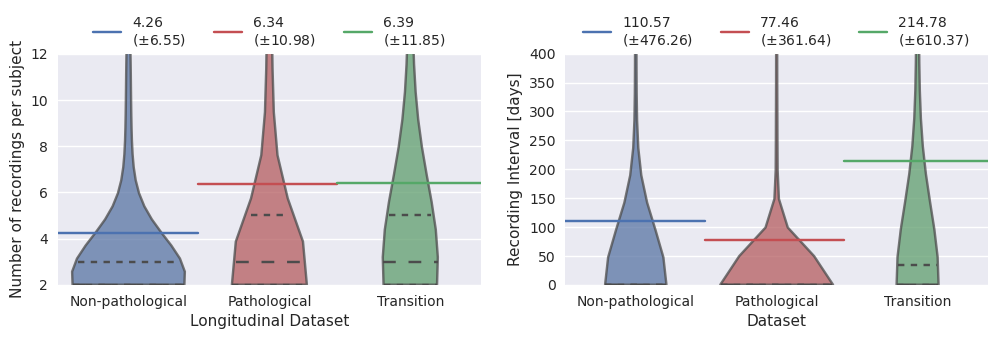

In [471]:
ax_arr[0].set_ylim(2,12)
ax_arr[1].set_ylim(0,400)
ax_arr[0].get_figure()

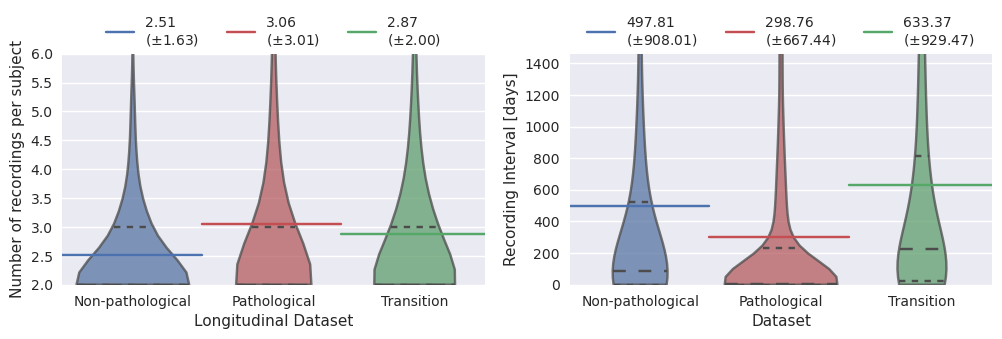

In [452]:
plot_n_recs_per_subject_and_rec_intervals(n_recs_per_subject, day_diffs)

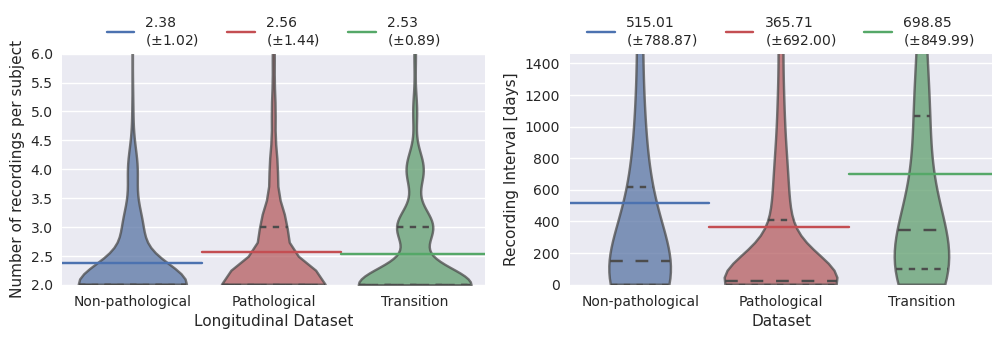

In [431]:
plot_n_recs_per_subject_and_rec_intervals(n_recs_per_subject, day_diffs)

# look at interesting cases, e.g. very large EEG brain age gap

In [666]:
# TODO: absolute biggest gap or biggest gap on averge?
def find_preds_of_subj_with_biggest_gap(all_rec_preds, ds_name, gap_sign, top):
    if ds_name is not None:
        long_rec_preds = all_rec_preds[all_rec_preds['Longitudinal']==ds_name]
    else:
        long_rec_preds = all_rec_preds
    all_rec_preds['gap'] = all_rec_preds.y_pred - all_rec_preds.y_true
    yes = False
    if yes:
        all_rec_preds['gap'] = all_rec_preds.gap.abs()
    long_subj_preds = long_rec_preds.groupby(
        ['subset', 'subject', 'pathological'], as_index=False).mean(numeric_only=True)
    #gaps = long_subj_preds.y_pred - long_subj_preds.y_true
    gaps = long_subj_preds.gap
    for idx, gap in gaps.sort_values(ascending=gap_sign=='-').head(top).tail(1).items():
        _
    subject = long_subj_preds.iloc[idx].subject
    for seed, group in long_rec_preds[long_rec_preds.subject==subject].groupby('seed'):
        #if seed == 20230216:
            break
    return gap, group

# look at most precise predictions

In [677]:
tmp = all_rec_preds.copy()

In [678]:
tmp['gap'] = (tmp.y_pred-tmp.y_true).abs()

In [699]:
name = 'longitudinal_non_pathological'

In [700]:
tmp[tmp.subset==name].groupby(['subject'], as_index=False).sum(numeric_only=True).gap.min()

1.739314168691628

In [701]:
tmp[tmp.subset==name].groupby(['subset', 'subject'], as_index=False).sum(numeric_only=True).gap.argmin()

45

In [702]:
tmp[tmp.subset==name].groupby(['subset', 'subject'], as_index=False).sum(numeric_only=True).iloc[45].subject

2298

In [703]:
all_rec_preds[all_rec_preds.subject==2298]

,y_true,y_pred,path,version,year,month,day,subject,session,segment,...,train,IMPRESSION,subset,seed,valid_set_i,date_age,report_age,duration,Longitudinal,gap
index,,,,,,,,,,,,,,,,,,,,,
505,35.999999,36.352202,/home/jovyan/mne_data/TUH/tuh_eeg/v1.1.0/edf/0...,v1.1.0,2005,2,14,2298,1,1,...,True,IMPRESSION: Normal EEG in wakefulness and drow...,longitudinal_non_pathological,20230214,0,36.0,35.0,1453.0,Non-pathological,0.352203
506,39.000000,37.612888,/home/jovyan/mne_data/TUH/tuh_eeg/v1.1.0/edf/0...,v1.1.0,2008,5,13,2298,2,0,...,True,IMPRESSION: EEG within normal limits.,longitudinal_non_pathological,20230214,0,39.0,38.0,1387.0,Non-pathological,-1.387112


In [704]:
all_rec_preds[all_rec_preds.subject==2298].pathological

index
505    0
506    0
Name: pathological, dtype: int64

In [705]:
for r in all_rec_preds[all_rec_preds.subject==2298].report:
    print(r)

CLINICAL HISTORY: This is a 35-year-old woman with seizures in childhood, in remission since age 7, now with new onset seizures in 2003.  Last seizure was three weeks ago with a frequency  of once a  month.    Generalized tonic-clonic seizures  with loss of  consciousness, postictal confusion, and sleepiness.   She also reports a few seizures during sleep, but doesn't know when. Patient diagnosed with depression and HIV in June 2004.
MEDICATIONS:  Erythromycin, Effexor, Buspirone, Pravachol, and Carbamazepine. INTRODUCTION: Digital video EEG is performed in the lab using standard 10-20 system of
electrode placement with one channel of EKG. Hyperventilation and photic stimulation were performed. This is an awake and asleep record.
DESCRIPTION OF THE  RECORD:  In wakefulness, the background EEG is well organized and symmetric with an 11 Hz posterior dominant rhythm with low voltage, frontotemporal beta activity.   Patient had a normal variant of 14 and 6 Hz positive spikes.     Hypervent

In [674]:
ds_name = 'Non-pathological'
sign = '-'  # +,-
top = 1  # integer

In [675]:
gap, group = find_preds_of_subj_with_biggest_gap(
    all_rec_preds, 
    ds_name, 
    sign, 
    top,
)

In [676]:
gap

-36.34204995135466

In [636]:
cols = [
    'y_true', 'y_pred', 'year', 'subject', 'pathological', 'duration', 'Longitudinal', 
    'report_age', 'date_age', 'age', 'session', 'segment']
group[cols]

,y_true,y_pred,year,subject,pathological,duration,Longitudinal,report_age,date_age,age,session,segment
index,,,,,,,,,,,,
250,66.999999,28.980930,2004,1218,0,1139.0,Non-pathological,67.0,67.0,67,2,0
253,66.999999,31.425873,2004,1218,0,1500.0,Non-pathological,67.0,67.0,67,2,5
254,66.999999,31.567043,2004,1218,0,1500.0,Non-pathological,67.0,67.0,67,2,7


In [637]:
# TODO: -1 y_true super weird. check what is happening! not super weird. was unclean age rec

In [638]:
for index, (y,m,d,r) in group[['year', 'month', 'day', 'report']].iterrows():
    print(y,m,d)
    print(r.strip())
    print()

2004 9 22
CLINICAL HISTORY: This is a 67-year-old male with hypertension, diabetes, prostate cancer, and right carotid stenosis.
MEDICATIONS: Diovan, Metformin, aspirin, Plavix, and Glipizide.
INTRODUCTION: Digital video EEG is performed in the lab using standard 10-20 system of electrode placement with one channel of EKG. Photic stimulation was performed.  This is an awake and asleep record.
DESCRIPTION OF THE RECORD: In wakefulness, the background EEG is well organized, low voltage, with a 9.5 Hz, 20 uV posterior dominant rhythm.  The EEG is symmetric and reactive to eye opening.  Photic stimulation elicits minimal driving.
HR:  78 BPM.
IMPRESSION: Normal EEG in wakefulness.
CLINICAL CORRELATION: No focal or epileptiform features were identified in this record.

2004 9 22
CLINICAL HISTORY: This is a 67-year-old male with hypertension, diabetes, prostate cancer, and right carotid stenosis.
MEDICATIONS: Diovan, Metformin, aspirin, Plavix, and Glipizide.
INTRODUCTION: Digital video EEG 